In [44]:
import keras 
from keras.layers import Input, Dense, Flatten, Lambda, Reshape, Conv2D, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend as k
import numpy as np
tf.compat.v1.disable_eager_execution()

In [45]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [46]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [47]:
#normalize data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train/ 255
x_test = x_test/ 255

In [48]:
#reshape data
img_height= x_train.shape[1]
img_width = x_train.shape[2]
num_channels = 1 #gray image
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
input_shape= (img_height, img_width, num_channels)

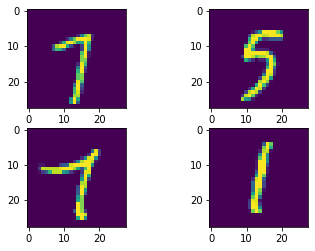

In [49]:
#display some images
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train[42][:,:,0])

plt.subplot(222)
plt.imshow(x_train[420][:,:,0])

plt.subplot(223)
plt.imshow(x_train[4200][:,:,0])

plt.subplot(224)
plt.imshow(x_train[42000][:,:,0])

In [50]:
#making the model
latent_dim =2

input_img= Input(shape= input_shape, name='encoder_input')
x= Conv2D(32,3, padding='same', activation='relu')(input_img)
x= Conv2D(64, 3, padding='same', activation='relu',strides=(2,2))(x)
x= Conv2D(64, 3, padding='same', activation='relu')(x)
x= Conv2D(64, 3, padding='same', activation='relu')(x)

conv_shape= k.int_shape(x)
print(conv_shape)

(None, 14, 14, 64)


In [51]:
#flatten
x= Flatten()(x)
x = Dense(32, activation='relu')(x)

In [52]:
# two output for latent mean and log_variance
# use these two sample  random variables in latent shape to which  inputs are mapped
z_mu = Dense(latent_dim, name='latent_mu')(x) #mean values of encoded input
z_sigma = Dense(latent_dim, name ='latent_sigma')(x) #std_var of encoded input

In [53]:
#REPARAMETARIZATION TRICK
def sample_z(args):
    z_mu,z_sigma = args
    eps = k.random_normal(shape=(k.shape(z_mu)[0], k.int_shape(z_mu)[1]))
    return z_mu +k.exp(z_sigma/2)*eps

In [54]:
 #zis the lambda custum layer we are adding to calculalte the gradient descent using mu and std
z= Lambda(sample_z, output_shape=(latent_dim,), name='z')([z_mu, z_sigma])

In [55]:
#Z (lambda layer will be the last layer of encoder)
encoder = Model(input_img,[z_mu, z_sigma, z], name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_9[0][0]                   
____________________________________________________________________________________________

In [56]:
#DECODER
#decoder takes latent vector as input
decoder_input = Input(shape=(latent_dim),name='decoder_input')

#we need to start from the shape that can remapped to original image shape
x= Dense(conv_shape[1]*conv_shape[2]*conv_shape[3],activation='relu')(decoder_input)
#reshape to the shape of last conv layer in the encoder
x= Reshape((conv_shape[1],conv_shape[2], conv_shape[3]))(x)
#now lets upscale back the the origianl shape using conv2Dtranspose
x= Conv2DTranspose(32,3,padding='same',activation='relu')(x)
x= Conv2DTranspose(num_channels,3, padding='same',activation="sigmoid",strides=(2,2))(x)

decoder = Model(decoder_input,x,name='decoder')
decoder.summary()

#now apply the decoder to the latent sample
z_decoded = decoder(z)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 12544)             37632     
_________________________________________________________________
reshape_5 (Reshape)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_________________________________________________________________


In [57]:
#Loss fuction for VAE
class CustomLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded):
        x= k.flatten(x)
        z_decoded = k.flatten(z_decoded)
        #reconstruction loss
        recon_loss = keras.metrics.binary_crossentropy(x,z_decoded)
        
        #KL divergence
        kl_loss = -5e-4 *k.mean(1+ z_sigma - k.square(z_mu) -k.exp(z_sigma),axis=1)
        return k.mean(recon_loss + kl_loss)
    
    #add custom loss to the class
    def call(self, inputs):
        x= inputs[0]
        z_decoded= inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs= inputs)
        return x
    
y= CustomLayer()([input_img, z_decoded])
#y is basically the original image after incoding input img and decoding sampled z values

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [58]:
#VAE

vae =Model(input_img, y, name='vae')

vae.compile(optimizer='adam',loss=None)
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_9[0][0]                   
________________________________________________________________________________________________

In [59]:
vae.fit(x_train, None, epochs=10,batch_size=32, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - ETA: 0s - loss: 0.2374WARNING:tensorflow:From C:\Users\nitin\.conda\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
48000/48000 [==============================] - 91s 2ms/sample - loss: 0.2374 - val_loss: 0.2085
Epoch 2/10
48000/48000 [==============================] - 90s 2ms/sample - loss: 0.2045 - val_loss: 0.1996
Epoch 3/10
48000/48000 [==============================] - 97s 2ms/sample - loss: 0.1976 - val_loss: 0.1951
Epoch 4/10
48000/48000 [==============================] - 93s 2ms/sample - loss: 0.1936 - val_loss: 0.1910
Epoch 5/10
48000/48000 [==============================] - 94s 2ms/sample - loss: 0.1912 - 

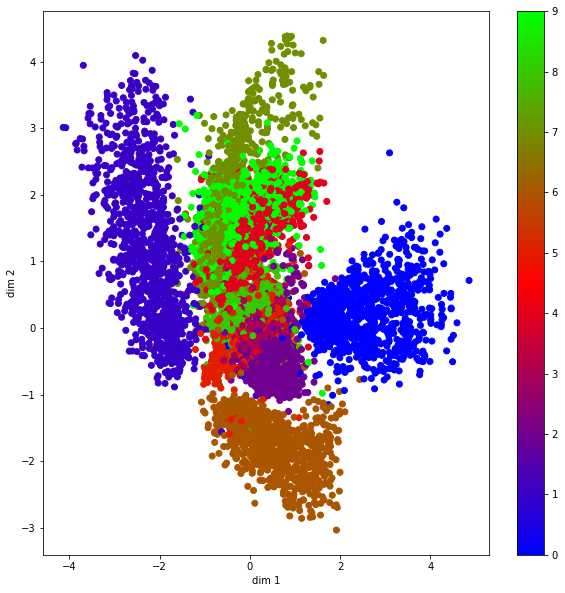

In [61]:
# =================
# Visualize results
# =================
#Visualize inputs mapped to the Latent space
#Remember that we have encoded inputs to latent space dimension = 2. 
#Extract z_mu --> first parameter in the result of encoder prediction representing mean

mu, _, _ = encoder.predict(x_test)
#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()


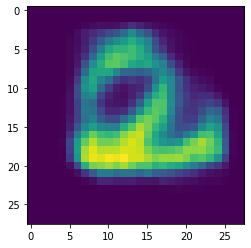

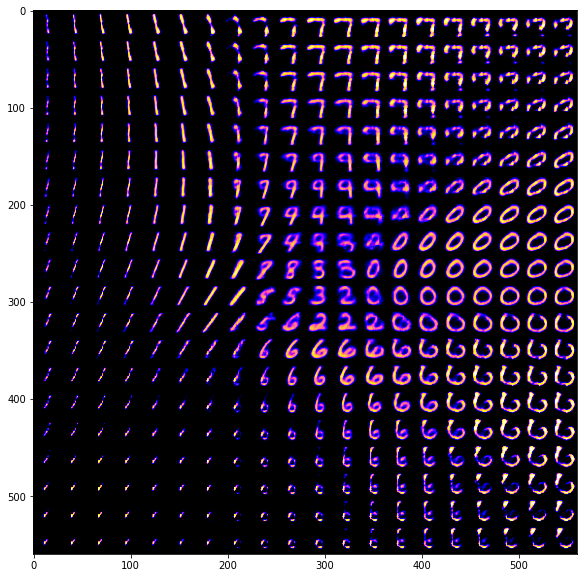

In [62]:
# Visualize images
#Single decoded image with random input latent vector (of size 1x2)
#Latent space range is about -5 to 5 so pick random values within this range
#Try starting with -1, 1 and slowly go up to -1.5,1.5 and see how it morphs from 
#one image to the other.
sample_vector = np.array([[1,-1]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)

#Let us automate this process by generating multiple images and plotting
#Use decoder to generate images by tweaking latent variables from the latent space
#Create a grid of defined size with zeros. 
#Take sample from some defined linear space. In this example range [-4, 4]
#Feed it to the decoder and update zeros in the figure with output.


n = 20  # generate 20*20 digits
figure = np.zeros((img_width * n, img_height * n, num_channels))

#Create a Grid of latent variables, to be provided as inputs to decoder.predict
#Creating vectors within range -5 to 5 as that seems to be the range in latent space
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)[::-1]

# decoder for each square in the grid
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_width, img_height, num_channels)
        figure[i * img_width: (i + 1) * img_width,
               j * img_height: (j + 1) * img_height] = digit

plt.figure(figsize=(10, 10))
#Reshape for visualization
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure, cmap='gnuplot2')
plt.show()  